<a href="https://colab.research.google.com/github/MamadouBarri/ML/blob/master/Histogram-kNN-KDE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Basic Libraries

`%pylab inline` imports the basic libraries (numpy, matplotlib)


In [ ]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


---

# Iris Flower Dataset

The Iris flower data set is a multivariate data set introduced by the British statistician and biologist Ronald Fisher in his 1936 paper The use of multiple measurements in taxonomic problems. The data set consists of 50 samples from each of three species of Iris (Iris Setosa, Iris virginica, and Iris versicolor). Four features were measured from each sample: the length and the width of the sepals and petals, in centimeters.

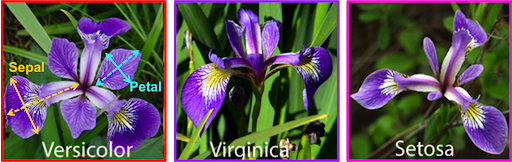

For our use case, we will only consider two species of Iris. (Iris versicolor and Iris virginica) This is a simple binary classification problem. $(0 = versicolor, 1 = virginica)$

In [ ]:
flower_classes = {
    "Iris-versicolor" : 0,
    "Iris-virginica" : 1,
    "Iris-setosa" : 2
}

data = np.loadtxt("http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data", delimiter=",", encoding="ascii", converters = {4: flower_classes.get})
data = data[50:] # Only select versicolor and virginica flowers

np.random.seed(42) # Set a constant seed for reproductibility
np.random.shuffle(data) # Randomly shuffle the dataset

print("Dataset shape:", data.shape) # Print shape of dataset

Dataset shape: (100, 5)


The input data is 4-dimensional. Using numpy indexing, we can choose which features to keep. For now, we will keep all 4 features.

In [ ]:
data_x = data[:, (0, 1, 2, 3)]
data_y = data[:, -1].astype(np.uint8)

print("First 10 entries of the dataset:")
print(data_x[0:10])
print(data_y[0:10])

First 10 entries of the dataset:
[[6.3 2.8 5.1 1.5]
 [6.3 2.9 5.6 1.8]
 [6.9 3.2 5.7 2.3]
 [5.7 3.  4.2 1.2]
 [5.6 2.7 4.2 1.3]
 [5.5 2.5 4.  1.3]
 [6.3 2.5 4.9 1.5]
 [7.4 2.8 6.1 1.9]
 [5.  2.  3.5 1. ]
 [7.  3.2 4.7 1.4]]
[1 1 1 0 0 0 0 1 0 0]


---

## Histogram Method (Classification)

We can separate the input space in chunks, and make predictions based on the known data points.

Implement the histogram method as described in the slides.

In [ ]:
# Initializes and returns a multidimensional array of zeroes of size [divs * divs * ... * divs] (dims times)
def initialize_histogram(dims, divs):
    return np.zeros(np.repeat(divs, dims))

# Returns the minimum and the maximum values of the input features in dataset_x
def get_scale(dataset_x):
    return np.min(dataset_x, axis=0), np.max(dataset_x, axis=0)

# Returns the class (0 or 1) depending on the value of pred_y. Eg. 0 if smaller than 0.5, else 1
def get_class(pred_y):
    return np.where(pred_y < 0.5, 0, 1).item()

# Takes in the number of divisions (divs), and the training dataset
# Outputs the trained histogram, and the histogram's scale for use in prediction (same as get_scale)
# This trained histogram should save the probability of being class 1. (Average of all labels (0 or 1) if doing binary classification)
def train_histogram(divs, dataset_x, dataset_y):
    dims = dataset_x.shape[1]
    histogram_sum = initialize_histogram(dims, divs)
    histogram_count = initialize_histogram(dims, divs)
    min_scale, max_scale = get_scale(dataset_x)

    for x, y in zip(dataset_x, dataset_y):
        # Scale our example data Ex. x = [6.3 2.8 5.1 1.5]
        # In order to achieve a ratio between 0 and 1 with respect to min/max
        # values of input 
        x_scale = (x - min_scale) / (max_scale - min_scale)
        # Create a tuple index with scaled values with respect to divs
        x_scaled_int = tuple(np.round(x_scale * (divs - 1)).astype(np.uint))
        # Increase the hisogram_sum by the value of y (the specified class)
        histogram_sum[x_scaled_int] += y
        # Increase the count of histogram_count by 1 in order to get the average
        histogram_count[x_scaled_int] += 1

    return histogram_sum / histogram_count, min_scale, max_scale 

# Takes in one unknown input, the trained histogram and the scale
# Outputs the predicted class
def predict_histogram(x, histogram, scale_min, scale_max):
    divs = histogram.shape[0]
    # Scale example {x} data with scale_min and scale_max
    x_scale = (x - scale_min) / (scale_max - scale_min)
    x_scale_int = tuple(np.round(x_scale * (divs - 1)).astype(np.uint))
    # Return the class in specified region
    return get_class(histogram[x_scale_int])

# Takes in unknown inputs, the trained histogram and the scale
# Outputs the array of predictions
def predict_histogram_batch(unknowns_x, histogram, scale_min, scale_max):
    predictions = []
    for x in unknowns_x:
        predictions.append(predict_histogram(x, histogram, scale_min, scale_max))
    return np.array(predictions)

# The same function can be simplified to one line!
def predict_histogram_batch(unknowns_x, histogram, scale_min, scale_max):
    return np.array([predict_histogram(x, histogram, scale_min, scale_max) for x in unknowns_x])

#### Unit Tests
These unit tests can be run to verify the histogram implementation.

In [ ]:
# Unit tests for histogram


assert initialize_histogram(3, 6).shape == (6, 6, 6)
assert initialize_histogram(1, 1).shape == (1,)


test_dataset_x = [(-0.5, 1, 5.1), (2.0, 0.0, 1.1), (1.2, -0.2, 3.0)]
test_scale_min, test_scale_max = get_scale(test_dataset_x)

assert (test_scale_min == [-0.5, -0.2, 1.1]).all()
assert (test_scale_max == [ 2.0,  1.0, 5.1]).all()

assert get_class(0.0) == 0
assert get_class(1.0) == 1
assert get_class(0.1) == 0
assert get_class(0.3) == 0
assert get_class(0.7) == 1
assert get_class(0.9) == 1

test_dataset_x = array([
       [-3.90532401, -1.08369859],
       [-3.75562443,  4.56415698],
       [ 2.97989322, -2.41017348],
       [ 0.88554229,  4.82330515],
       [ 3.84198978,  1.00798446],
       [ 4.03723967,  4.8918491 ],
       [ 2.43352823, -4.35013591],
       [-0.98419764,  3.37825735],
       [-2.69430804,  3.30642518],
       [-3.79661238, -4.53054643],
       [-1.15909389, -4.63268063],
       [ 4.57270263,  3.26205696],
       [ 3.00769687,  1.29777923],
       [-2.83675977,  0.18260367],
       [ 0.10240073,  0.05690267]])

test_dataset_y = array([1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0])

test_histogram, test_scale_min, test_scale_max = train_histogram(3, test_dataset_x, test_dataset_y)

assert (test_histogram == array([
        [1. , 0.5, 1. ],
        [0.5, 0. , 0.5],
        [0. , 0.5, 1. ]])).all()

assert (test_scale_min == [-3.90532401, -4.63268063]).all()
assert (test_scale_max == [4.57270263, 4.8918491]).all()


test_histogram = array([
        [1. , 0.1, 1. ],
        [0.6, 0. , 0.3],
        [0. , 0.1, 1. ]])

test_dataset_x = array([
       [ 4.62121973, -3.9053114 ],
       [ 3.94479931,  4.91475335],
       [-4.38482974,  3.82906269],
       [ 0.1607902 ,  4.06513719],
       [ 0.71318942,  1.6211201 ],
       [ 0.43778908,  3.6449288 ],
       [ 2.33909919,  0.21260312],
       [ 3.68160804, -2.54714468],
       [-3.4265934 , -3.39599895],
       [-1.65991121, -2.61309969]])

test_dataset_y = array([0, 1, 1, 0, 0, 0, 0, 0, 1, 1])

assert predict_histogram(test_dataset_x[2], test_histogram, test_scale_min, test_scale_max) == test_dataset_y[2]
assert predict_histogram(test_dataset_x[5], test_histogram, test_scale_min, test_scale_max) == test_dataset_y[5]
assert predict_histogram(test_dataset_x[6], test_histogram, test_scale_min, test_scale_max) == test_dataset_y[6]

assert (predict_histogram_batch(test_dataset_x, test_histogram, test_scale_min, test_scale_max) == test_dataset_y).all()

print("Done. All tests have passed.")

Done. All tests have passed.


### Histogram - Exercices
1. Train a histogram with 5 sub-divisions per dimension and print the histogram's array (or an inner slice if the array is too big to print). What do you observe? Is data uniformly distributed within the histogram?
    
    * We can observe that the data is not evenly distributed throughout the histogram. In fact, most of the regions where we have any data are in the 'middle' of the histogram (in the center of the multidimensionnal space).    

---


2. What happens if you increase the number of sub-divisions to 9? What happens if you reduce it to 3 instead? Discuss.

    * Obviously, we get more regions and therefore the matrices get bigger and we have more NaN regions where none of the points from the dataset were counted. Also, since the regions are very small and our dataset is relatively small too, we have almost no regions where an average was calculated. It is mostly either isolated points that take up the whole region or Nan as previously stated. On the other hand, if we reduce the number of divisions to three, we get less regions and smaller matrices. We also get more actually averages of the classes (1, 0) in some of the regions. 

--- 

3. Implement a function that counts the number of empty regions in a histogram.
 
---

4. Knowing that a mostly empty histogram is problematic, suggest and implement a simple solution for this dataset. (Hint: Four input features is too much)
    
    * Four features makes our space 4 dimensional and therefore we have many empty regions in our space: Dimensianality curse. Therefore, we need to reduce the amout of features that we take from the dataset or minimize the number of divions we have in our space. We should opt for the second solution in this problem.

---

5. Train a new histogram with 5 sub-divisions using your solution and compare the resulting histogram with the one obtained in **1)** using the function implemented in **3)**.

In [ ]:
# 1.
histogram_trained_first, scale_min_first, scale_max_first = train_histogram(5, data_x, data_y)
histogram_trained_first[:, :, :, 3].flatten()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan,  1., nan, nan, nan, nan,  1., nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,  1.,  1., nan,
       nan, nan,  1.,  1., nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan,  1.,  1., nan, nan,
       nan, nan,  1., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan,  1., nan, nan, nan,  1.,  1., nan, nan,
       nan, nan, nan, nan, nan, nan,  1.,  1.])

In [ ]:
# 2.
histogram_trained, scale_min, scale_max = train_histogram(9, data_x, data_y)
print(histogram_trained[:, :, :, 5].flatten()[9 ** 3 // 2:])
print('---------------------------------------------')
print(histogram_trained[:, :, :, 6].flatten()[:9 ** 3 // 2])

[nan  1. nan nan nan nan nan nan nan  1. nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan  1. na

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


In [ ]:
# 3.
histogram_trained, scale_min, scale_max = train_histogram(3, data_x, data_y)
histogram_trained

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


array([[[[0.   ,   nan,   nan],
         [0.   ,   nan,   nan],
         [  nan,   nan,   nan]],

        [[0.   , 0.   ,   nan],
         [0.   , 0.5  ,   nan],
         [  nan,   nan,   nan]],

        [[  nan,   nan,   nan],
         [  nan,   nan,   nan],
         [  nan,   nan,   nan]]],


       [[[  nan,   nan,   nan],
         [0.   , 0.5  ,   nan],
         [  nan,   nan,   nan]],

        [[0.   ,   nan,   nan],
         [0.   , 0.575, 1.   ],
         [  nan,   nan, 1.   ]],

        [[  nan,   nan,   nan],
         [  nan, 0.   , 1.   ],
         [  nan,   nan,   nan]]],


       [[[  nan,   nan,   nan],
         [  nan,   nan,   nan],
         [  nan,   nan,   nan]],

        [[  nan,   nan,   nan],
         [  nan, 1.   ,   nan],
         [  nan, 1.   , 1.   ]],

        [[  nan,   nan,   nan],
         [  nan,   nan,   nan],
         [  nan, 1.   , 1.   ]]]])

In [ ]:
def count_nan(histogram):
    return np.sum(np.isnan(histogram))

In [ ]:
# 5
# When we take in consideration only 2 features we get a relatively 'full' histogram

histogram_trained_five, scale_min_five, scale_max_five = train_histogram(5, data_x[:,:2], data_y)
print('NaNs with 5 features:', count_nan(histogram_trained))
print('NaNs with 2 features:', count_nan(sol_trained_histogram))


NaNs with 5 features: 61
NaNs with 2 features: 8


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


6. Implement a function that computes the accuracy of predictions $f(data_x)$ by comparing them with the true values $data_y$.

7. Using the function implemented in **6)**, note and compare the accuracy of predictions between the two histograms obtained in **1)** and **5)**.

8. You should obtain a higher accuracy for the histogram with more input features. However, having many empty regions is bad. Are these two statements contradictory? How can a model have a higher accuracy and be bad at the same time? Discuss.

    * The accuracy is clearly better for the histogram model trained with more features. This is solely due to the fact that the training simply memorized the features (we have many regions containing single points for the dataset). However, this model is not all that great if we eventually test it with data that it was not trained with. It's accuracy will clearly suffer because many of the regions in the histogram will simply not have any values and therefore predicting any class would be impossible.  

In [ ]:
def accuracy(predicted_y, real_y):
    return 1 - np.mean(np.clip(np.abs(predicted_y - real_y), 0, 1))

# 7.
predicted_y_first = predict_histogram_batch(data_x, histogram_trained_first, scale_min_first, scale_max_first)
first_accuracy = accuracy(predicted_y_first, data_y)
predicted_y_five = predict_histogram_batch(data_x[:,:2], histogram_trained_five, scale_min_five, scale_max_five)
five_accuracy = accuracy(predicted_y_five, data_y)
print('Accuracy with 4 parameters:', first_accuracy)
print('Accuracy with 2 parameters:', five_accuracy)

Accuracy with 4 parameters: 0.97
Accuracy with 2 parameters: 0.72


---

## k-NN Method (Classification)
Implement the k-NN method as described in the slides.

In [225]:
# Distance function, returns the distance between x and y
def distance(x, y):
    # Let's use Euclidean distance 
    return np.sum((x - y) ** 2, axis=-1)


# Takes in one unknown input, training dataset, training labels and k
# Outputs the predicted class
def knn(x, dataset_x, dataset_y, k):
    argmin_indices = np.argsort(distance(x, dataset_x))
    k_nns = dataset_y[argmin_indices[0:k]]

    n_class_0 = np.sum(k_nns == 0)
    n_class_1 = np.sum(k_nns == 1)
    
    return 0 if n_class_0 > n_class_1 else (1 if n_class_1 > n_class_0 else -1)


# Takes in unknown inputs, training dataset, training labels and k (optional, default = 3)
# Outputs the array of predictions
def knn_batch(unknowns_x, dataset_x, dataset_y, k=3):
    return np.array([knn(x, dataset_x, dataset_y, k) for x in unknowns_x])


### k-NN - Exercices
9. Using the accuracy function implemented before, note and compare the accuracy of predictions on the same dataset $data_x$ used for training when varying $k$. Try larger values of $k$ first. $(19, 7, 5, 3, ...)$ What happens when $k=1$? Discuss.

    * We get good results with almost all the values of k. Obviously, when we get closer to $k=1$, we get almost perfect results because we are testing the accuracy of our model on a dataset that we used to train it. Therefore, the model simply memorizes the points and the KNN with k=1 is actually the same point. Therefore, we get a perfect accuracy.

In [228]:
predicted_by_20_knn = knn_batch(data_x, data_x, data_y, 20)
accuracy_by_20_knn = accuracy(predicted_by_20_knn, data_y)
print('Accuracy with k = 20: ', accuracy_by_20_knn)

predicted_by_10_knn = knn_batch(data_x, data_x, data_y, 10)
accuracy_by_10_knn = accuracy(predicted_by_10_knn, data_y)
print('Accuracy with k = 10: ', accuracy_by_10_knn)

predicted_by_5_knn = knn_batch(data_x, data_x, data_y, 5)
accuracy_by_5_knn = accuracy(predicted_by_5_knn, data_y)
print('Accuracy with k = 5: ', accuracy_by_5_knn)

predicted_by_1_knn = knn_batch(data_x, data_x, data_y, 1)
accuracy_by_1_knn = accuracy(predicted_by_1_knn, data_y)
print('Accuracy with k = 1:', accuracy_by_1_knn)

Accuracy with k = 20:  0.97
Accuracy with k = 10:  0.95
Accuracy with k = 5:  0.95
Accuracy with k = 1: 1.0


---

## KDE Method / Soft Parzen Windows (Classification)
Implement the KDE method as described in the slides.

In [236]:
# Gaussian kernel function with sigma s
def kernel(x, s):
    return np.exp(-(x**2)/(s**2)) # Generalized "gaussian-like" kernel equation: e^-|x|^p / s^p

# Takes in one unknown input, training dataset, training labels and sigma
# Outputs the predicted class
def kde(x, dataset_x, dataset_y, s):
    # For each point: compute distance and weight using the kernel function. Sum all, for each class
    weights = kernel(distance(x, dataset_x), s)

    class_0_weights = np.sum(weights[dataset_y == 0])
    class_1_weights = np.sum(weights[dataset_y == 1])

    # Distance of each point
    return 0 if class_0_weights > class_1_weights else 1

# Takes in unknown inputs, training dataset, training labels and sigma (optional, default = 4)
# Outputs the array of predictions
def kde_batch(unknowns_x, dataset_x, dataset_y, s=4):
    return np.array([kde(x, dataset_x, dataset_y, s) for x in unknowns_x])

### KDE - Exercices
10. Using the accuracy function implemented before, note and compare the accuracy of predictions on the same dataset $data_x$ used for training when varying $\sigma$ (variable s). Try larger values of $\sigma$ first. $(10, 5, 1, 0.1, 0.01, ...)$ What happens when $\sigma$ is very small? Discuss.

    * When we lower $\sigma$, the weights of the closest points to the unknown x become greater and therefore have more influence on the predicted class. Essentially lowering our sigma to 0.01 makes the weight of the closest point to the unknown x so great, that it almost renders the values of other points void. It is basically equivalent a KNN training with k = 1.

In [237]:
for s in [10,5,1,0.1,0.01]:
    print(f'With s={s}, the accuracy was: ', accuracy(kde_batch(data_x, data_x, data_y, s), data_y))

With s=10, the accuracy was:  0.84
With s=5, the accuracy was:  0.85
With s=1, the accuracy was:  0.94
With s=0.1, the accuracy was:  0.99
With s=0.01, the accuracy was:  1.0
